Basic file reading and data exploration

In [124]:
import h5py
import numpy as np
import math
from scipy.spatial.transform import Rotation as R

# fname = 'd4/20220302_131424.hdf5'
# fname = '20220408_191041.hdf5'
# fname = '20220408_210049.hdf5' # 3 strokes
# fname = '20220409_184944.hdf5' # perpendicular drill angle
# fname = '20220409_185037.hdf5' # varying drill angle

# fname = 'Angles/45deg.hdf5' # 45 degree drill angle
fname = 'Angles/90deg.hdf5' # 90 degree drill angle
# fname = 'Angles/random.hdf5' # random drill angle

f = h5py.File(fname, 'r')
print('File keys', f.keys())
print(type(f))

File keys <KeysViewHDF5 ['burr_change', 'data', 'force', 'metadata', 'voxels_removed']>
<class 'h5py._hl.files.File'>


In [125]:
data = f['data']
print('Data keys', data.keys())
# print((data['depth'][()]).shape)
# print((data['l_img'][()]).shape)
# print((data['pose_main_camera'][()]).shape)
print((data['pose_mastoidectomy_drill'][()]).shape)
# print((data['r_img'][()]).shape)
print((data['segm'][()]).shape)
print((data['time'][()]).shape)

# Not necessary for our purposes

# b_cg = f['burr_change']
# print('Burr Change keys', b_cg.keys())

# meta = f['metadata']
# print('Metadata keys', meta.keys())
# print((meta['README'][()]))

force = f['force']
print('Force keys', force.keys())
print((force['time_stamp'][()]).shape)
print((force['wrench'][()]).shape)

v_rm = f['voxels_removed']
print('Voxels Removed keys', v_rm.keys())
print((v_rm['time_stamp'][()]).shape)
print((v_rm['voxel_color'][()]).shape)
print((v_rm['voxel_removed'][()]).shape)

# # Time differences between either time stamps unequal

# print((data['time'][1]) - (data['time'][0]))
# print((data['time'][435]) - (data['time'][434]))
# print((v_rm['time_stamp'][1]) - (v_rm['time_stamp'][0]))
# print((v_rm['time_stamp'][435]) - (v_rm['time_stamp'][434]))

# print(min(data['time'][()]), max(data['time'][()]))

print(min(data['time'][()]) == min(data['time'][()]))

Data keys <KeysViewHDF5 ['depth', 'l_img', 'pose_main_camera', 'pose_mastoidectomy_drill', 'r_img', 'segm', 'time']>
(117, 7)
(117, 480, 640, 3)
(117,)
Force keys <KeysViewHDF5 ['time_stamp', 'wrench']>
(49581,)
(49581, 3)
Voxels Removed keys <KeysViewHDF5 ['time_stamp', 'voxel_color', 'voxel_removed']>
(14813,)
(14813, 4)
(14813, 3)
True


Function implementation

In [126]:
def get_strokes(stream: np.ndarray, timepts: np.ndarray, k=6):
    stream = stream[:, :3]
    X_P = []

    # Compute k-cosines for each pivot point
    for j,P in enumerate(stream):
        
        # Cannot consider edge points as central k's
        if (j - k < 0) or (j + k >= stream.shape[0]):
            continue

        P_a = stream[j - k]
        P_c = stream[j + k]

        k_cos = np.dot(P_a, P_c) / (np.linalg.norm(P_a) * np.linalg.norm(P_c))
        k_cos = max(min(k_cos, 1), -1)
        X_P.append(180 - (math.acos(k_cos) * (180/np.pi)))

    # Detect pivot points
    mu = np.mean(X_P)
    sig = np.std(X_P)

    for i in range(k):
        
        X_P.insert(0, mu)
        X_P.append(mu)

    X_P = np.array(X_P)

    F_c = [1 if x_P > mu + sig else 0 for x_P in X_P]

    j = 0
    for i in range(1, len(F_c)):

        if F_c[i] == 1 and F_c[i-1] == 0:
            j += 1
        elif sum(F_c[i:i+k]) == 0 and j != 0:
            ind = math.floor(j/2)
            F_c[i-j:i] = [0] * j
            F_c[i-ind] = 1
            j = 0
        elif j != 0:
            j += 1

    st = np.insert(timepts[[s == 1 for s in F_c]], 0, min(timepts))

    return F_c, st

strokes, stroke_times = get_strokes(data['pose_mastoidectomy_drill'][()], data['time'][()])

In [127]:
def stats_per_stroke(stroke_arr: np.ndarray):
    
    mean = np.mean(stroke_arr)
    med_ = np.median(stroke_arr)
    max_ = np.max(stroke_arr)

    return mean, med_, max_

In [128]:
def stroke_force(strokes: np.ndarray, stroke_times: np.ndarray,
                force_stream: np.ndarray, force_times: np.ndarray):

    avg_stroke_force = []
    for i in range(sum(strokes)):

        stroke_mask = [ft >= stroke_times[i] and ft < stroke_times[i+1] for ft in force_times]
        stroke_forces = np.linalg.norm(force_stream[stroke_mask], axis=1)
        avg_stroke_force.append(np.mean(stroke_forces))

    return np.array(avg_stroke_force)
    

stroke_force(strokes, stroke_times, force['wrench'][()], force['time_stamp'][()])

array([0.        , 0.        , 0.        , 0.17338839])

In [129]:
def stroke_length(strokes: np.ndarray, stream: np.ndarray):

    stream = stream[:, :3]
    
    lens = []
    inds = np.insert(np.where(strokes == 1), 0, 0)
    for i in range(sum(strokes)):
        stroke_len = 0
        curr_stroke = stream[inds[i]:inds[i+1]]
        for j in range(1, len(curr_stroke)):

            stroke_len += np.linalg.norm(curr_stroke[j-1] - curr_stroke[j])

        lens.append(stroke_len)

    return np.array(lens)

stroke_length(np.array(strokes), data['pose_mastoidectomy_drill'][()])

array([1.33645189e-05, 5.28233733e-02, 4.69498310e-02, 1.10024546e-01])

In [130]:
def bone_removal_rate(strokes: np.ndarray, stroke_times: np.ndarray,
                        stream: np.ndarray, voxel_times: np.ndarray):
    
    vox_rm = []
    for i in range(sum(strokes)):

        stroke_voxels = [vt >= stroke_times[i] and vt < stroke_times[i+1] for vt in voxel_times]
        vox_rm.append(sum(stroke_voxels))

    rate = np.divide(np.array(vox_rm), stroke_length(np.array(strokes), stream))

    return rate

bone_removal_rate(strokes, stroke_times, data['pose_mastoidectomy_drill'][()], v_rm['time_stamp'][()])

array([    0.        ,     0.        ,     0.        , 79427.73075289])

In [131]:
def procedure_duration(timepts: np.ndarray):
    return (max(timepts) - min(timepts))

procedure_duration(data['time'][()])

49.412348985672

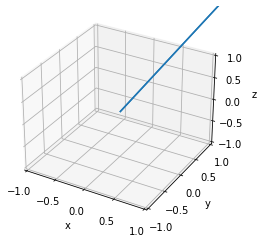

In [154]:
import matplotlib.pyplot as plt


def drill_orientation(stream: np.ndarray, timepts: np.ndarray,
                      voxels: np.ndarray, voxel_times: np.ndarray):
    
    
    
    angles = []
    normals = []
    drill_vecs = []
    for i,t in enumerate(timepts):
        ind = np.argmin(np.abs(voxel_times - t))
        if np.isclose(np.abs(voxel_times[ind] - t), 0):
            # print(sum([np.isclose(np.abs(v - voxel_times[ind]), 0) for v in voxel_times]))
            # if sum([np.isclose(v - voxel_times[ind], 0) for v in voxel_times]) >= 3:
            #     print(ind)
            #     print('howdy')
            #     return

            # Just use three closest
            ind2 = 0
            ind3 = 0
            if ind < len(voxel_times) - 15:
                ind2 = ind+1
                ind3 = ind+2
            elif ind > 1:
                ind2 = ind-1
                ind3 = ind-2

            x0, y0, z0 = voxels[ind]

            min_dist = np.inf
            for j in range(len(voxels)):
                curr_dist = np.linalg.norm(voxels[ind] - voxels[i])
                if curr_dist < min_dist:
                    ind2 = i
                    min_dist = curr_dist

            x1, y1, z1 = voxels[ind2]

            min_dist = np.inf
            for j in range(len(voxels)):
                curr_dist1 = np.linalg.norm(voxels[ind] - voxels[i])
                curr_dist2 = np.linalg.norm(voxels[ind2] - voxels[i])
                if (curr_dist1 + curr_dist2) < min_dist and (i != ind2):
                    ind3 = i
                    min_dist = curr_dist

            x2, y2, z2 = voxels[ind3]

            ux, uy, uz = [x1-x0, y1-y0, z1-z0]
            vx, vy, vz = [x2-x0, y2-y0, z2-z0]

            u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]
            normal = np.array(u_cross_v)

            v = R.from_quat(stream[i, 3:]).apply([np.cos(0.9), np.sin(0.9), 0])
            v = np.divide(v, np.linalg.norm(v))

            normals.append(normal)
            drill_vecs.append(v)

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            soa = np.array([np.insert(normal, 0, (0, 0, 0)), np.insert(normal, 0, (0, 0, 0))])

            X, Y, Z, U, V, W = zip(*soa)
            ax.quiver(X, Y, Z, U, V, W)
            ax.set_xlim([-1, 1])
            ax.set_ylim([-1, 1])
            ax.set_zlim([-1, 1])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')

            plt.show()
            return
    # normal = np.mean(normals, axis=0)
    normal = np.divide(normal, np.linalg.norm(normal))

    for v in drill_vecs:

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        soa = np.array([np.insert(normal, 0, (0, 0, 0)), np.insert(v, 0, (0, 0, 0))])

        X, Y, Z, U, V, W = zip(*soa)
        ax.quiver(X, Y, Z, U, V, W)
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

        plt.show()

        angle = np.arccos(np.clip(np.dot(v, normal), -1.0, 1.0)) * (180/np.pi)
        print(90 - angle)
        print()
        if angle > 90:
            angle = 180 - angle
        angles.append(90 - angle)

    print(np.mean(angles))
    return angles

drill_orientation(data['pose_mastoidectomy_drill'][()], data['time'][()], v_rm['voxel_removed'][()], v_rm['time_stamp'][()])

In [133]:
import cffi
import pathlib

""" Build the CFFI Python bindings """
ffi = cffi.FFI()

this_dir = pathlib.Path().absolute()
h_file_name = this_dir / "EdtReader/EdtReader.h"
with open(h_file_name) as h_file:
    ffi.cdef(h_file.read())

ffi.set_source(
    "EDTread",
    # Since you're calling a fully-built library directly, no custom source
    # is necessary. You need to include the .h files, though, because behind
    # the scenes cffi generates a .c file that contains a Python-friendly
    # wrapper around each of the functions.
    '#include "EdtReader.h"',
    # The important thing is to include the pre-built lib in the list of
    # libraries you're linking against:
    libraries=["EdtReader"],
    library_dirs=[this_dir.as_posix()],
    extra_link_args=["-Wl,-rpath,."],
)

ffi.compile()

/Users/alexandraszewc/opt/anaconda3/lib/python3.8/site-packages/cffi/cparser.py:154: UserWarning: String literal found in cdef() or type source. String literals are ignored here, but you should remove them anyway because some character sequences confuse pre-parsing.
  warnings.warn("String literal found in cdef() or type source. "


CDefError: cannot parse "#include <iostream>"
<cdef source string>:1:1: Directives not supported yet

In [ ]:
import EDTread